# Testing 3D Taylor-Couette

Using parameters from Section 4 of Marcus (JFM 1984),

$$\eta = 0.875$$
$$\lambda = L_z = 2\pi/\alpha = 3.00$$
$$ R = 2.063 R_c = 243.81$$

In [1]:
import h5py
import numpy as np

In [2]:
#datafile = "../scratch/TC_run_re4.58e+02_mu0.00e+00_eta8.68e-01_Lz3.00e+00_filter5.00e-01_nr64_ntheta64_nz64/slices/slices_s4.h5"
#datafile = "../scratch/TC_run_re2.44e+02_mu0.00e+00_eta8.75e-01_filter5.00e-01_nr64_ntheta64_nz64/slices/slices_s1.h5"
datafile = "../scratch/TC_run_re2.44e+02_mu0.00e+00_eta8.75e-01_Lz3.00e+00_filter5.00e-01_nr64_ntheta64_nz64/slices/slices_s4.h5"

In [3]:
data = h5py.File(datafile,'r')

In [4]:
data['/tasks/u'].shape

(20, 64, 64, 64)

In [5]:
eta = 0.868
omega1 = 1/eta - 1.
period = 2*np.pi/omega1


In [6]:
print("Sim time = {}".format(data['scales/sim_time'][:]/period))

Sim time = [ 6.38715767  6.49363257  6.60010482  6.70657673  6.8130498   6.91952396
  7.02599829  7.13246982  7.23894247  7.34541573  7.45189068  7.558364
  7.66483568  7.77130872  7.87778203  7.98425727  8.09033796  8.19680969
  8.30328314  8.40975733]


In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt

## Initial Conditions (r-theta plane)

In [8]:
r = data['scales/r/1.0'][:]
z = data['scales/z/1.0'][:]

In [9]:
rr, zz = np.meshgrid(r,z)

<IPython.core.display.Javascript object>


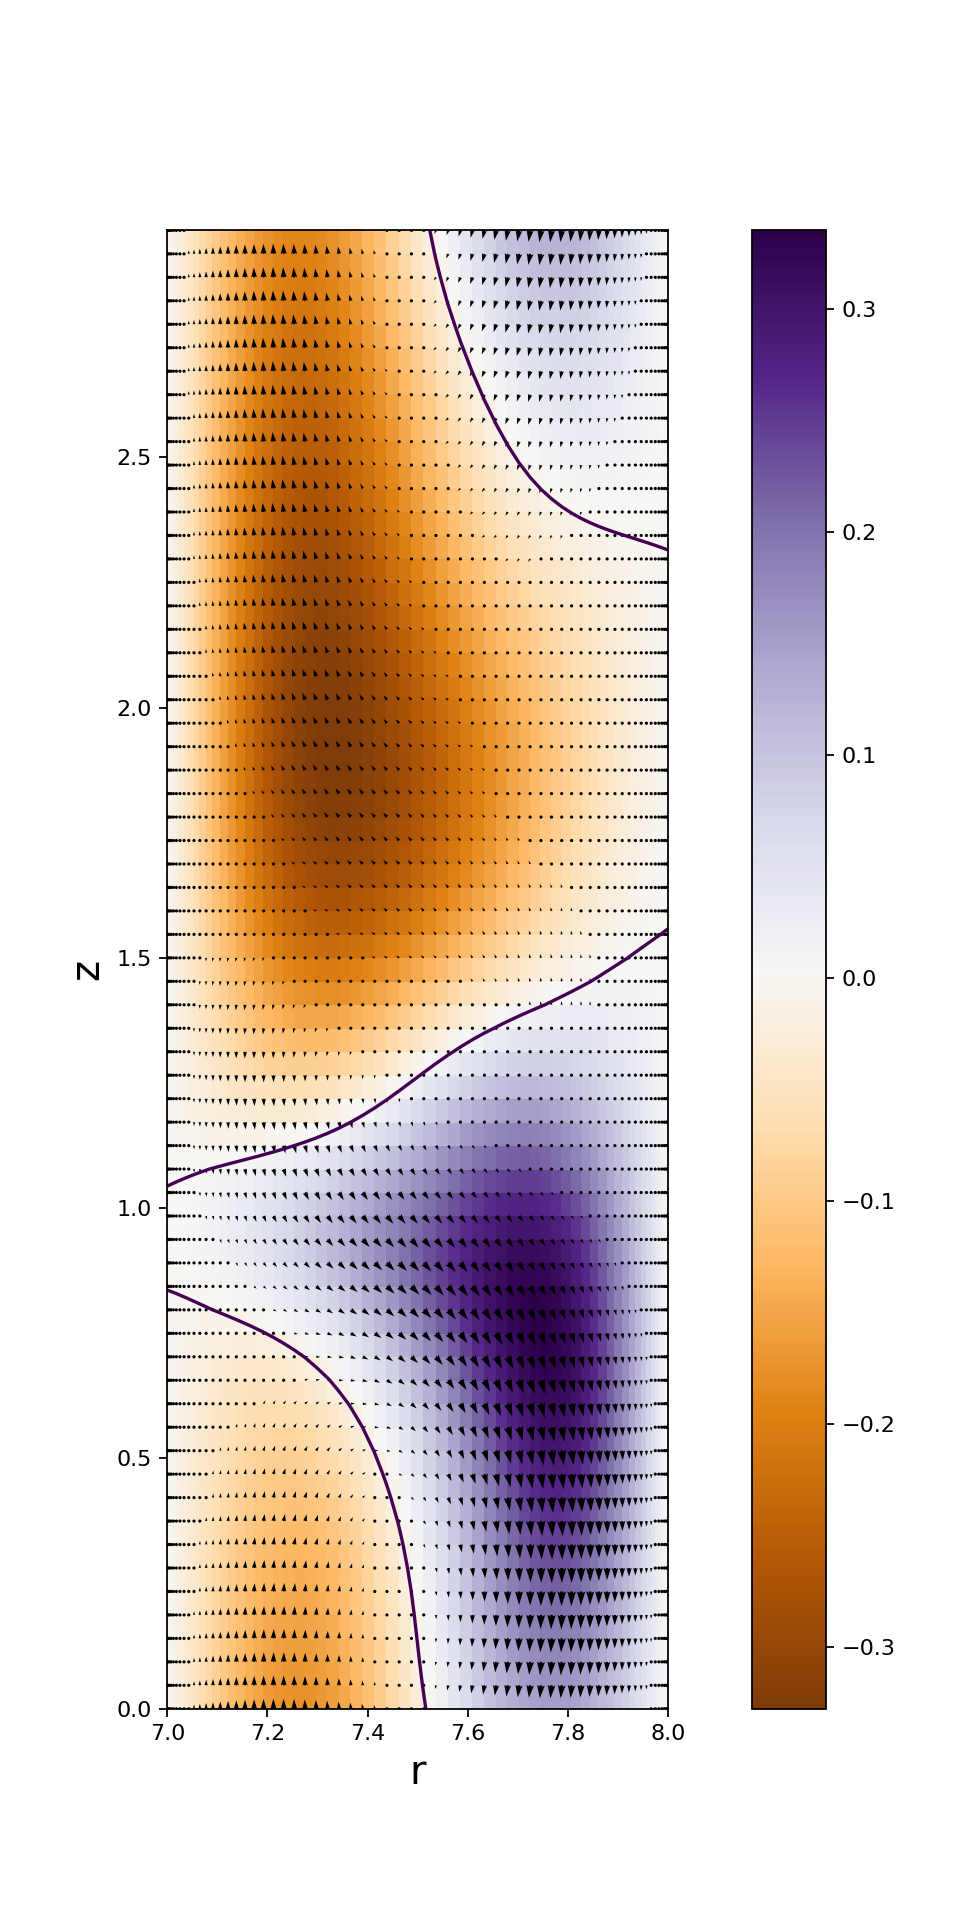

Text(0,0.5,'z')

In [10]:
m_idx = 30

plt.figure(figsize=(6,12))
#plt.figsize(12,8)
plt.pcolormesh(rr,zz,data['tasks/v'][-1,:,m_idx,:],cmap='PuOr')
plt.colorbar()
plt.contour(rr,zz,data['tasks/v'][-1,:,m_idx,:], levels=[0.,])
plt.quiver(rr,zz,data['tasks/u'][-1,:,m_idx,:],data['tasks/w'][-1,:,m_idx,:],width=0.007)
plt.axis('image')
plt.xlabel('r', fontsize=18)
plt.ylabel('z', fontsize=18)

In [11]:
w_mean = data['tasks/w'][0].mean(axis=1)

In [12]:
w_mean = np.repeat(w_mean[:,np.newaxis,:],64,axis=1)

<IPython.core.display.Javascript object>


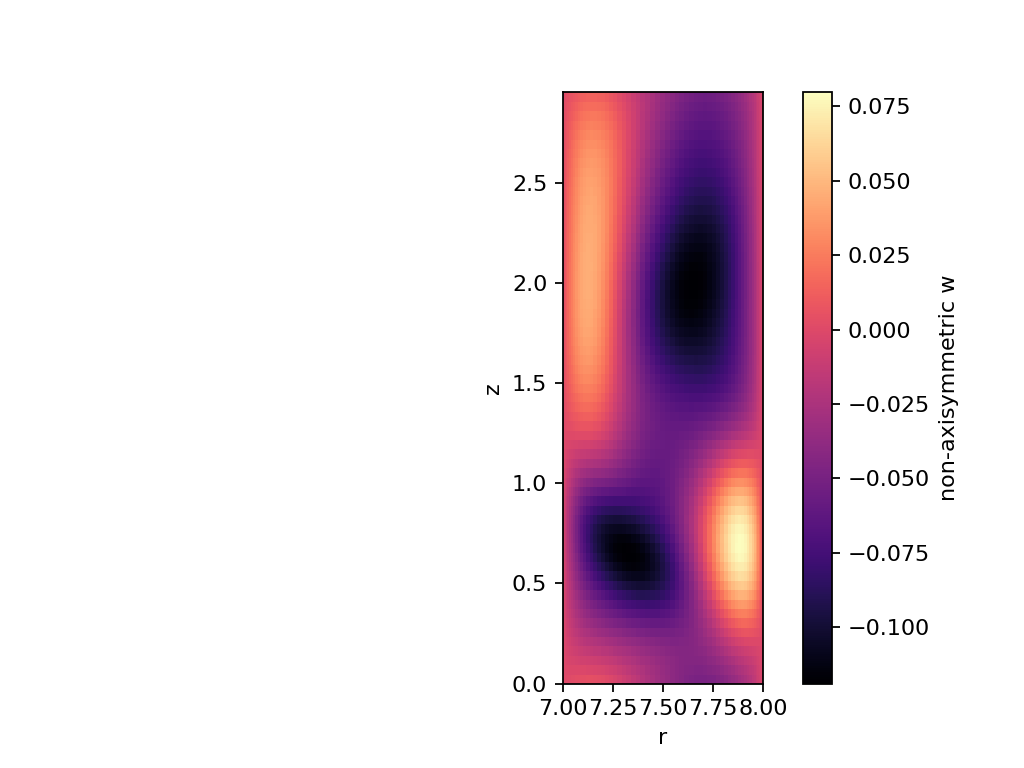

Text(0,0.5,'z')

In [13]:
plt.figure()
plt.pcolormesh(rr, zz, (data['tasks/w'][0,:,:,:]-w_mean)[:,40,:], cmap='magma')
plt.axis('image')
plt.colorbar(label='non-axisymmetric w')
plt.xlabel('r')
plt.ylabel('z')

## $r-z$ plane

In [14]:
m = data['scales/theta/1.0'][:]
rr, mm = np.meshgrid(r,m)

<IPython.core.display.Javascript object>


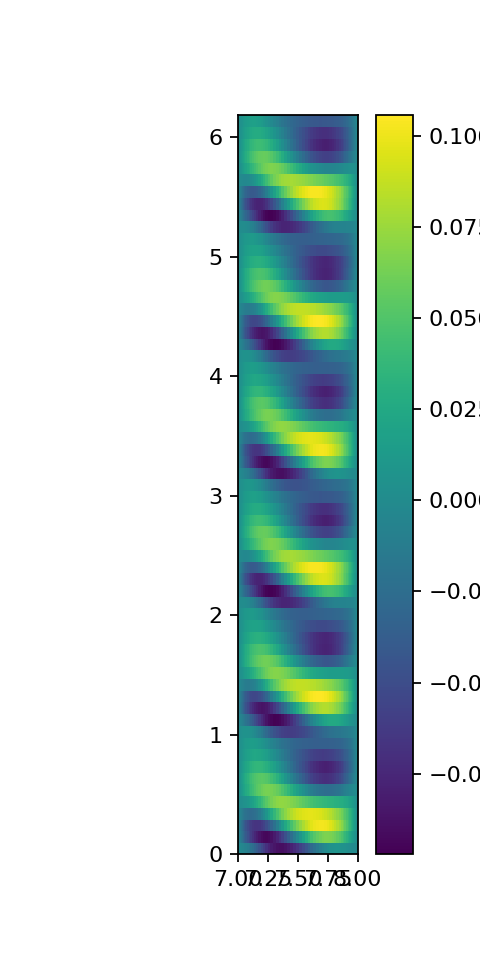

In [15]:
plt.figure(figsize=(3,6))
plt.pcolormesh(rr,mm,(data['tasks/w'][0]- w_mean)[60,:,:])
plt.axis('image')
plt.colorbar()

## $\theta-z$ plane

In [16]:
mm, zz = np.meshgrid(m,z)

<IPython.core.display.Javascript object>


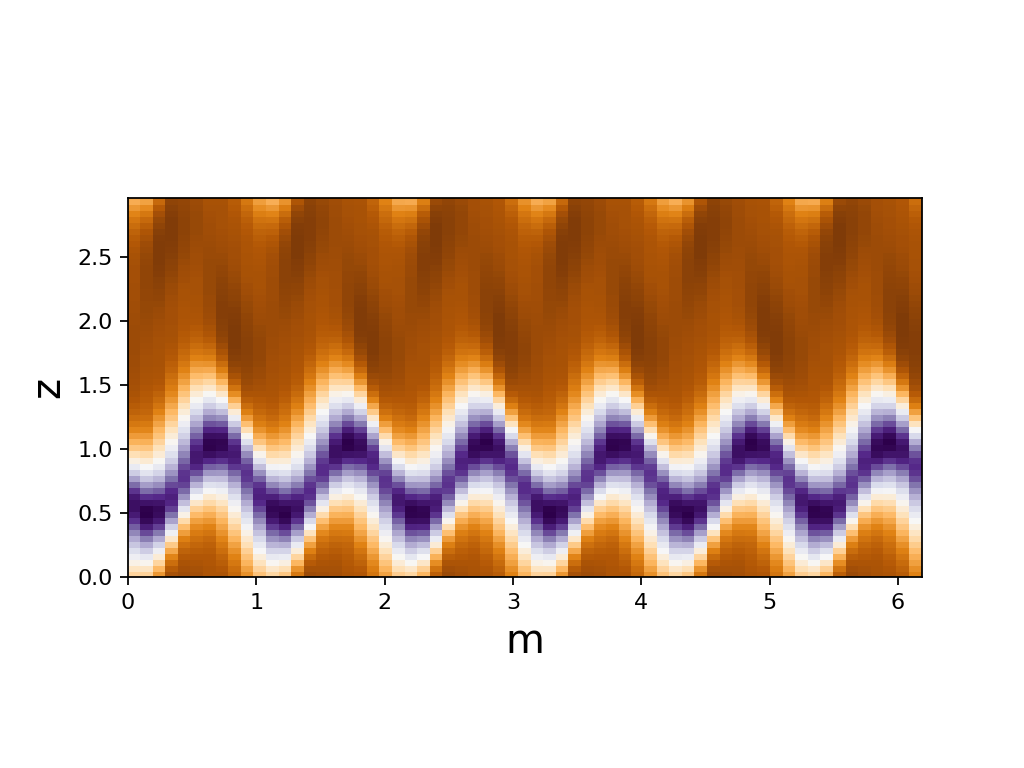

Text(0,0.5,'z')

In [17]:
plt.figure()#figsize=(8,4))
#plt.figsize(12,8)
plt.pcolormesh(mm,zz,data['tasks/u'][-1,:,:,31],cmap='PuOr')
#plt.colorbar()
#plt.quiver(mm,zz,data['tasks/v'][-1,:,:,31],data['tasks/w'][-1,:,:,31],width=0.007)
plt.axis('image')
plt.xlabel('m', fontsize=18)
plt.ylabel('z', fontsize=18)

## $r-\theta$ plane

<IPython.core.display.Javascript object>


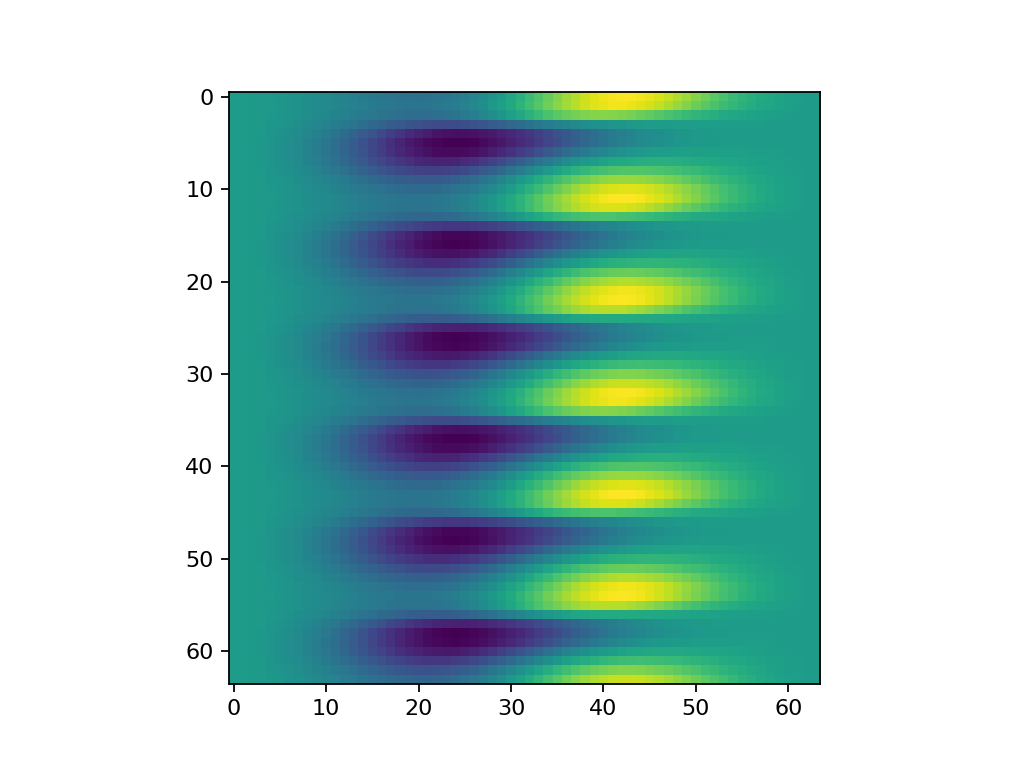

In [18]:
plt.figure()
plt.imshow(data['tasks/v'][-1,0])

In [19]:
%load_ext autoreload
%autoreload 2

In [20]:
from file_tools import fields_from_file

In [21]:
u = fields_from_file(datafile,['Fourier', 'Fourier', 'Chebyshev'],'u',index=-1)
v = fields_from_file(datafile,['Fourier', 'Fourier', 'Chebyshev'],'v',index=-1)
w = fields_from_file(datafile,['Fourier', 'Fourier', 'Chebyshev'],'w',index=-1)

In [22]:
z, theta, r = v.domain.grids()

In [23]:
z.shape

(64, 1, 1)

In [24]:
r.max()

7.9998494093481023

In [25]:
data['scales/r/1.0'][:].max()

7.9998494093481023

In [26]:
v['c'].shape

(32, 63, 64)

In [27]:
type(data) is h5py._hl.files.File

True

In [28]:
def calc_spectra(data, field=None, index=-1):
    if type(data) is h5py._hl.files.File:
        if field is None:
            raise ValueError("When using data from HDF5 files, you must specify a field.")
        field_name = 'tasks/{}c'.format(field)
        power = np.abs(data[field_name][index])
    else:
        power = np.abs(data['c'])
        
    return power

In [29]:
def plot_spectra(data, field=None, index=-1):
    
    power = calc_spectra(data, field, index)
    if field is None:
        field = data.name
    
    Tr_power = power.sum(axis=1).sum(axis=0)
    m_power = power.sum(axis=2).sum(axis=0)
    kz_power = power.sum(axis=2).sum(axis=1)
    
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.semilogy(Tr_power.real,'ko-')
    plt.xlabel('$T_r$')
    plt.ylabel('{} power'.format(field))
    
    plt.subplot(132)
    m_max = int(np.ceil(len(m_power)/2))
    plt.semilogy(m_power[:m_max].real, 'ko-')
    plt.xlabel('$m$')
    plt.ylabel('{} power'.format(field))

    
    plt.subplot(133)
    plt.semilogy(kz_power.real,'ko-')
    plt.xlabel('$k_z$')
    plt.ylabel('{} power'.format(field))

    plt.subplots_adjust()

<IPython.core.display.Javascript object>


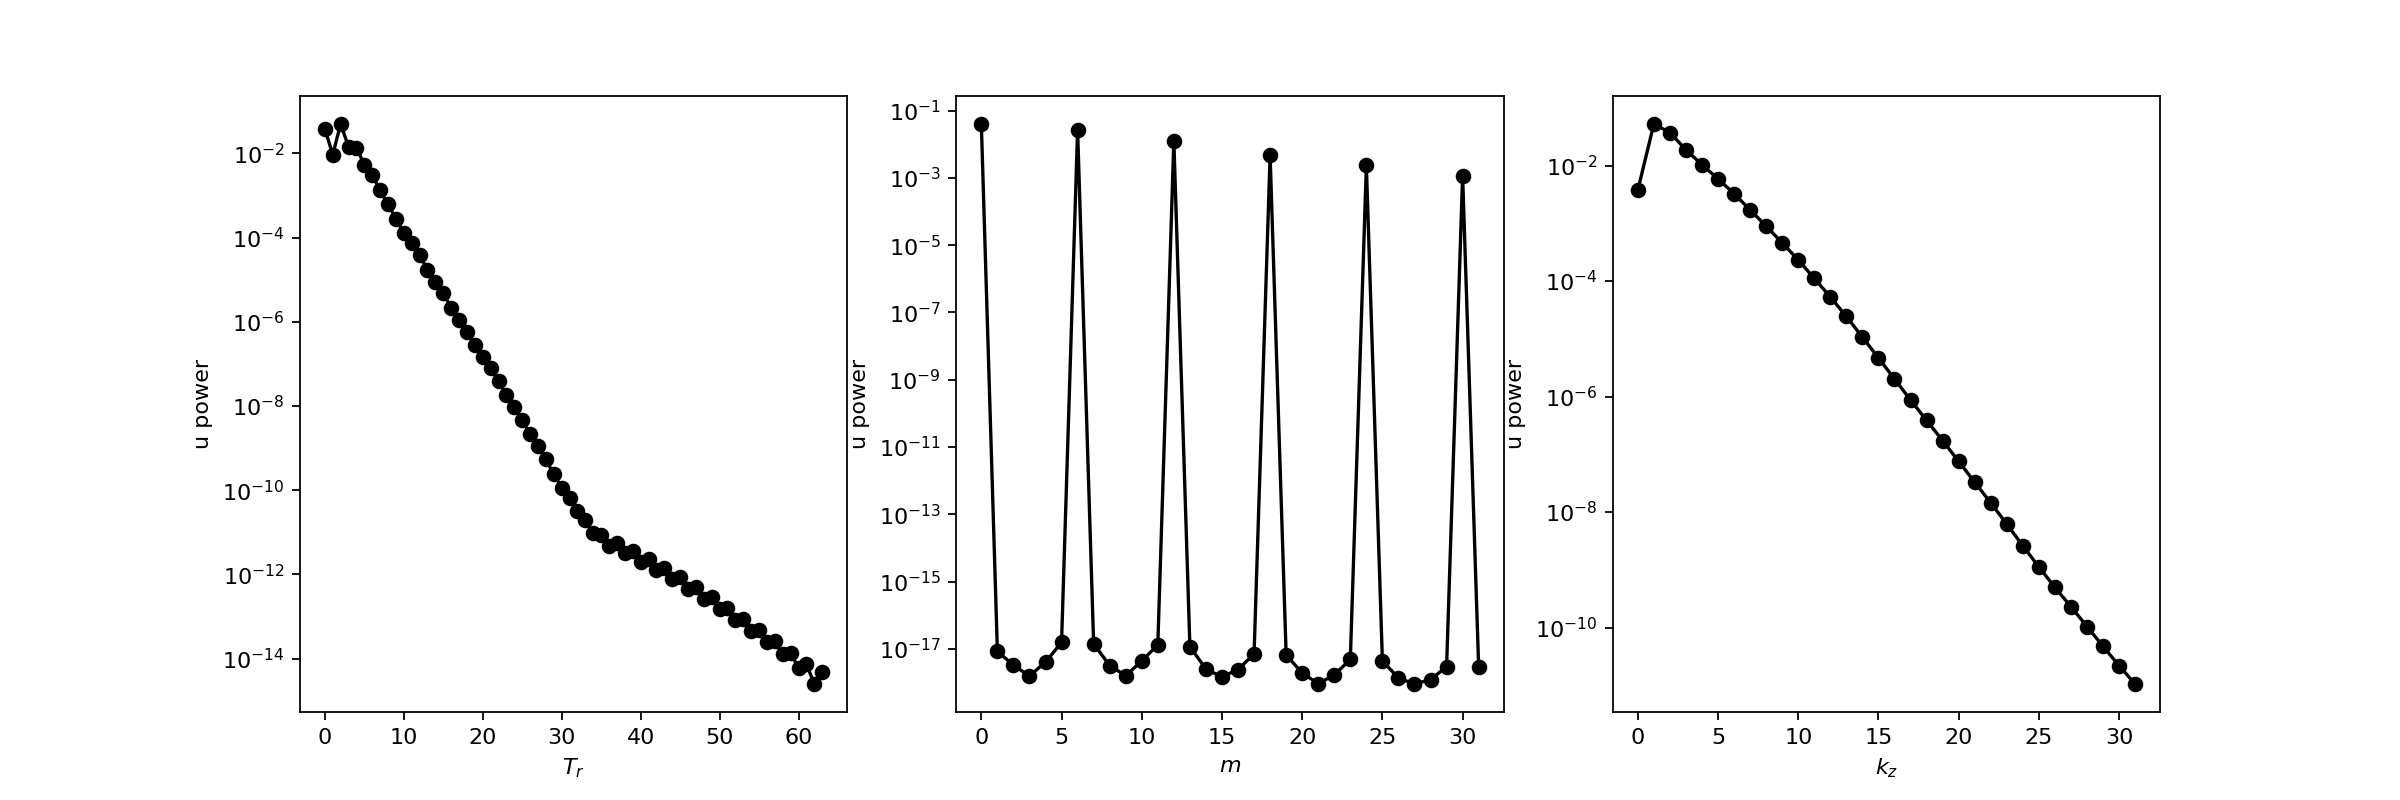

In [30]:
plot_spectra(data,'u',index=-1)
#plot_spectra(u)

<IPython.core.display.Javascript object>


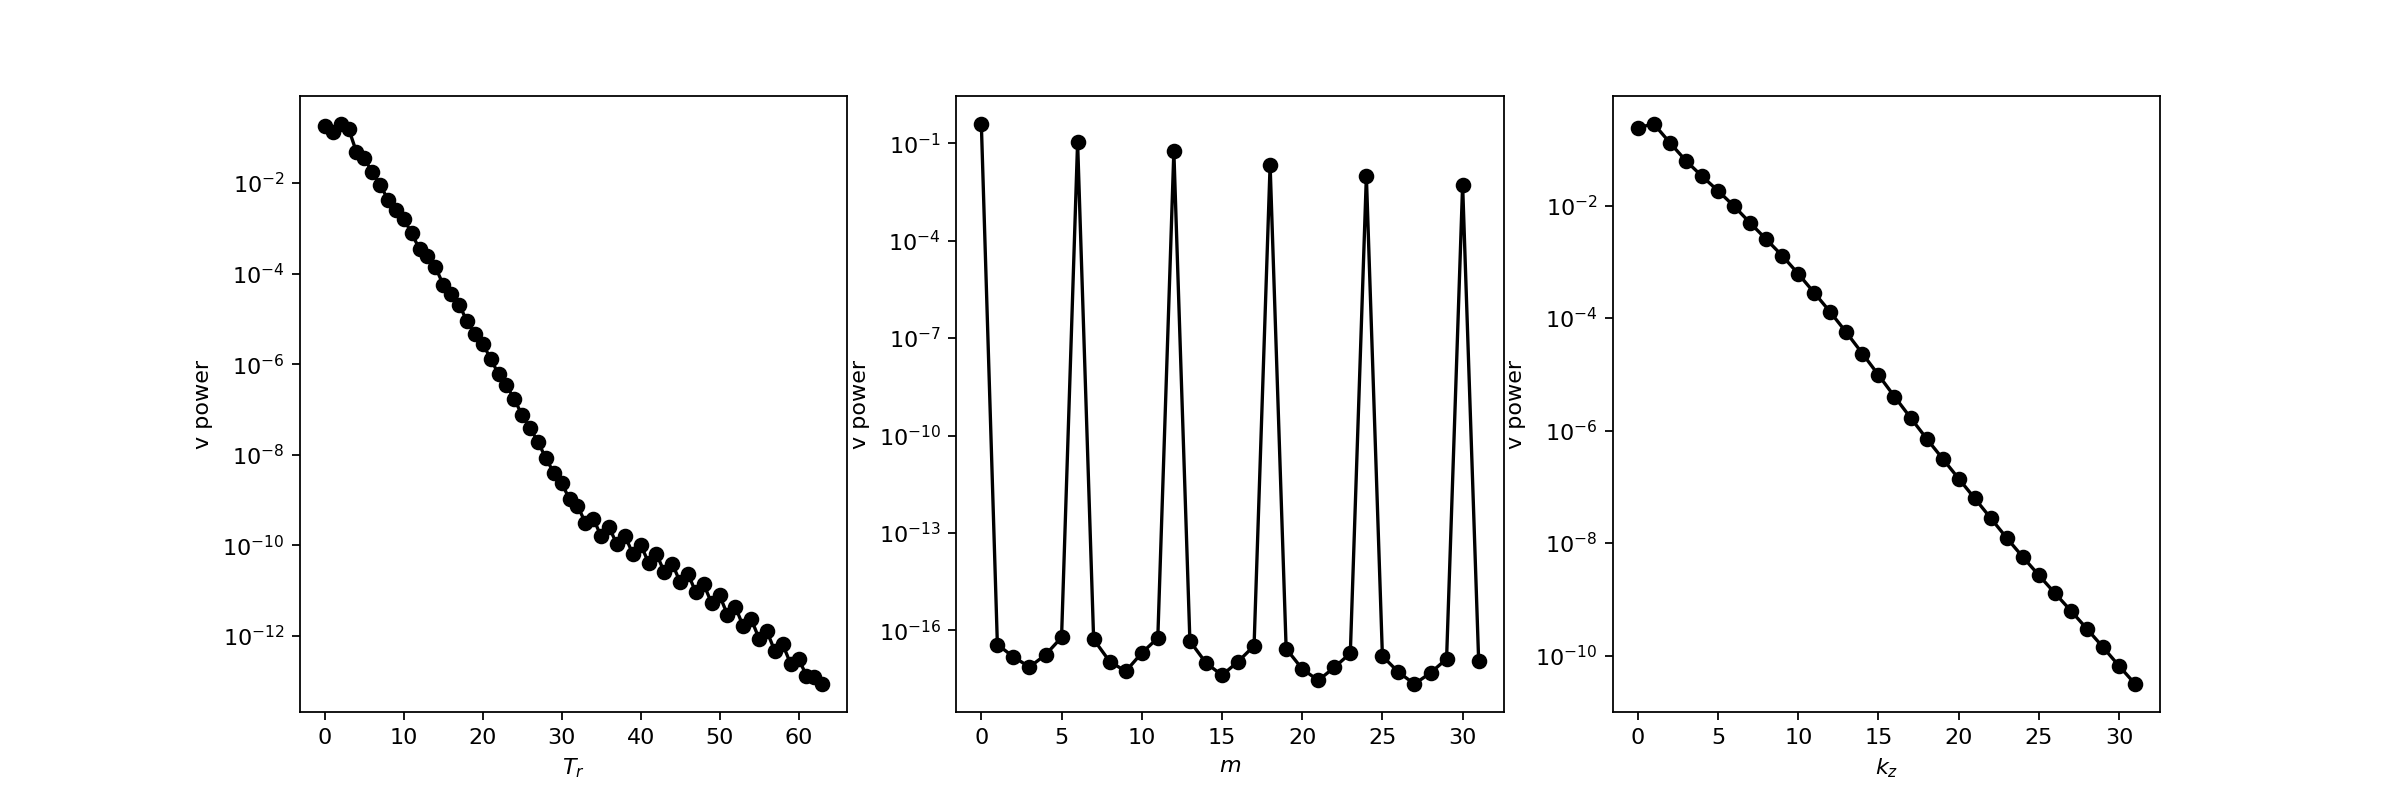

In [31]:
plot_spectra(data,'v',index=-1)
#plot_spectra(v)

<IPython.core.display.Javascript object>


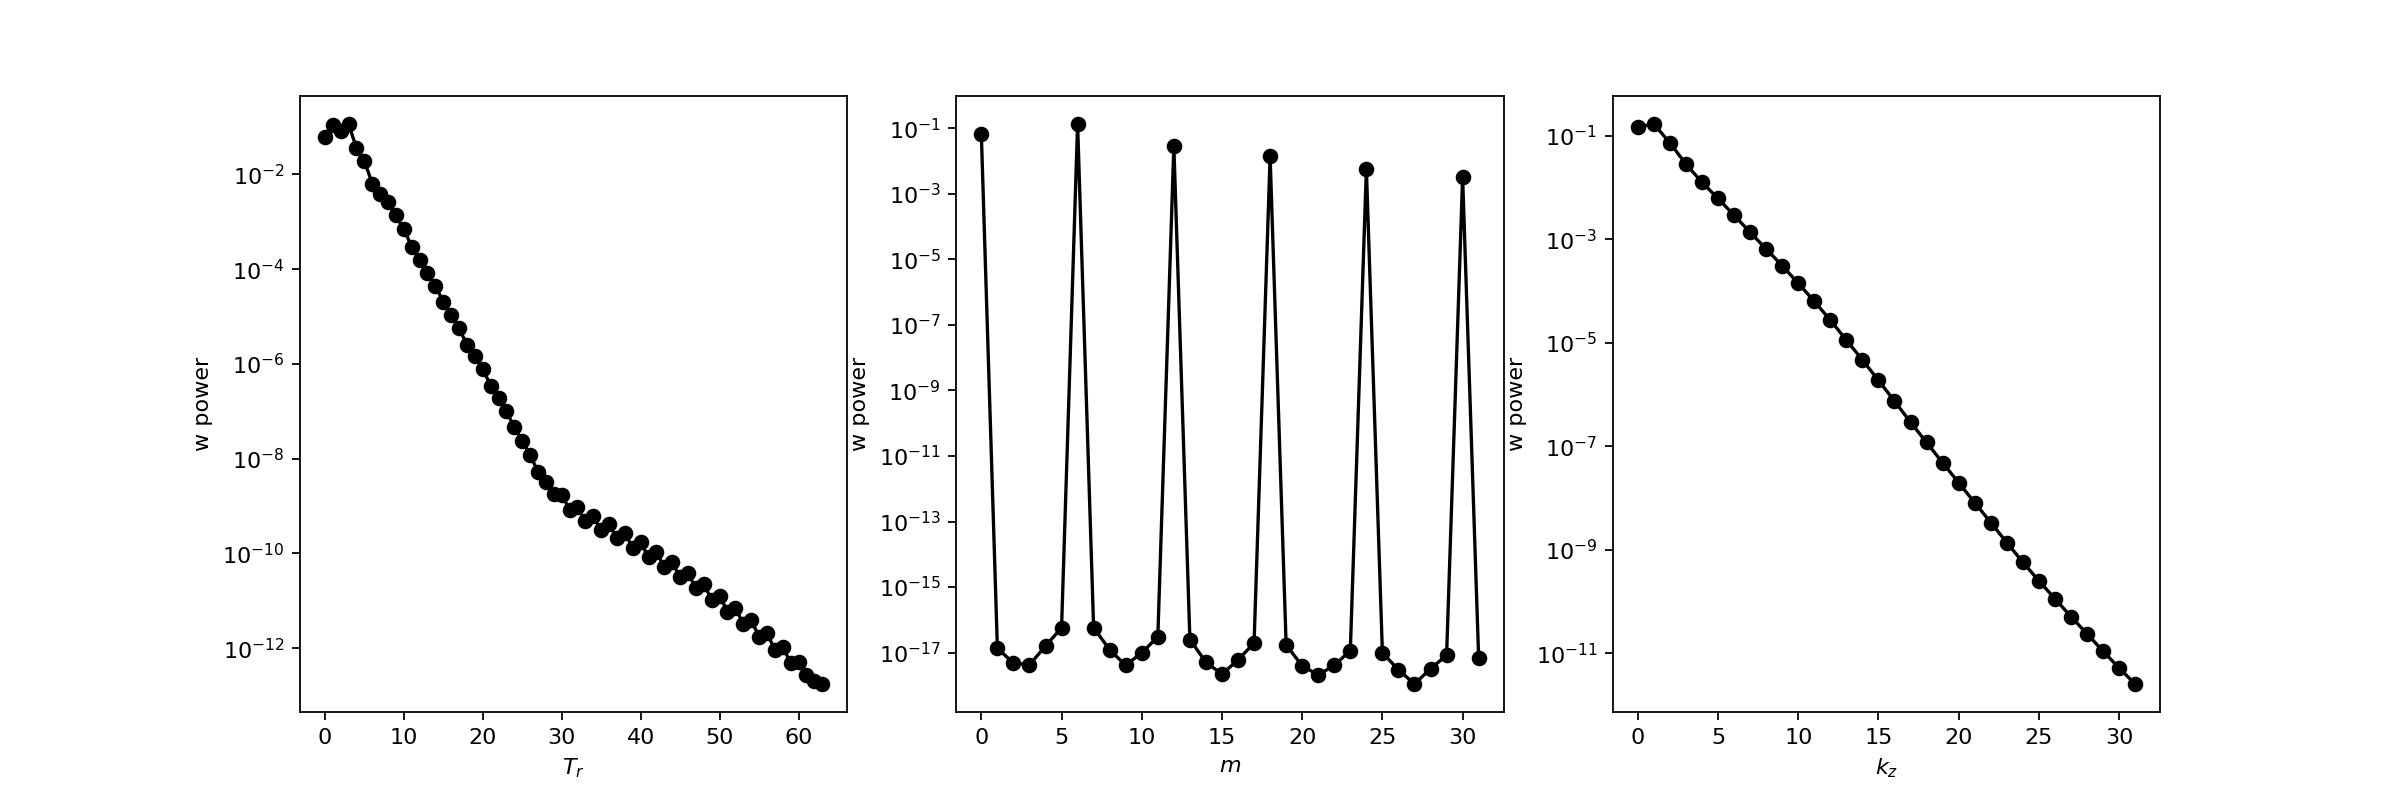

In [32]:
plot_spectra(data,'w', index=-1)
#plot_spectra(w)

In [33]:
import ipywidgets as widgets

<IPython.core.display.Javascript object>


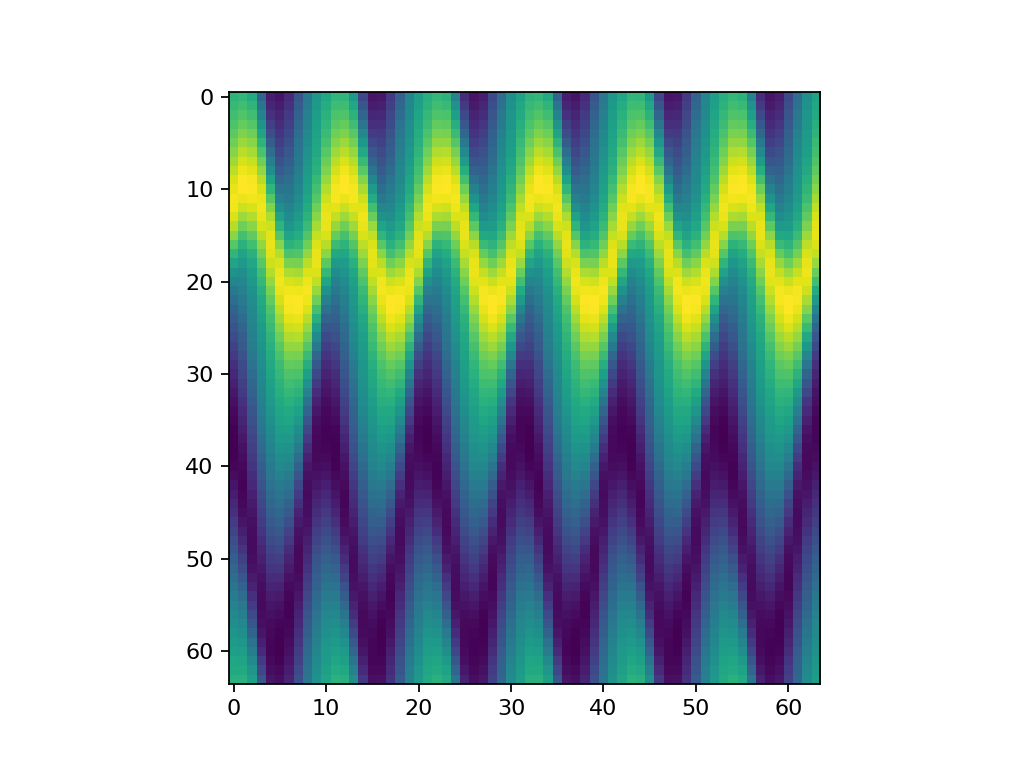

interactive(children=(IntSlider(value=31, description='m', max=63), Output()), _dom_classes=('widget-interact',))

In [34]:
plt.figure()
def f(m):
    plt.imshow(v['g'][:,:,m])
    plt.show()

interactive_plot = widgets.interactive(f, m=(0,63), continuous_update=False)
interactive_plot

In [35]:
list(data['tasks'].keys())

['u', 'uc', 'v', 'vc', 'w', 'wc']